## Setup

### Download required weights

In [1]:
## Download mask rcnn 
## Download depth map 
## !wget -q http://www.cs.cornell.edu/projects/megadepth/dataset/models/best_generalization_net_G.pth 
## !mv best_generalization_net_G.pth ./pretrain/depthmap.pth
## Download PyNet
## !wget -q http://yucanwu.com/share/pynet_bokeh_level_0.zip

!pwd

/Users/rainwu/Documents/ece496/capstone-pixelart/app/backend


## Load weights and build models

In [26]:
from libpixelartbokeh.ObjectDetection import ObejctDetection
from libpixelartbokeh.MegaDepthMap import MegaDepthMap
from libpixelartbokeh.PyNet import PyNet

objectDetectioModel = ObejctDetection(checkpoint_path="./pretrain/pretrain_maskrcnn.pt")
megaDepthMapModel = MegaDepthMap(checkpoint_path="./pretrain/depthmap.pth")
pyNet = PyNet(checkpoint_path="./pretrain/PyNET/aws_epoch_1000")
# pyNet = PyNet(checkpoint_path="./pretrain/PyNET/best.ckpt")
# pyNet = PyNet(checkpoint_path="./pretrain/PyNET/pynet_bokeh_level_0")

===========================================LOADING Hourglass NETWORK====================================================
model [HGModel] was created


## Test Models

In [27]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import traceback
import timeit

samples_path = Path("./res/samples")
results_path = Path("./res/results")
mask_results = []
depth_results = []
bokeh_results = []

for sample in samples_path.iterdir():
    if sample.is_file():
        # Load image
        s_time = timeit.default_timer()
        try:
            img = Image.open(sample).convert("RGB")
            ratio = np.min((2560 / img.size[0], 1440 / img.size[1]))
            new_shape = np.array((img.size[0] * ratio, img.size[1] * ratio)).astype(np.uint32)
            img = img.resize(new_shape, Image.ANTIALIAS) 
            img = np.array(img)
            print(f"Loaded image {str(sample)} with shape {img.size} new_shape {img.shape}", end="\t")
        except Exception as e:
            print(e)
            traceback.print_exc()
        print(f"Time spent: {timeit.default_timer() - s_time:7.3f}s")
            
        s_time = timeit.default_timer()
        # mask generation
        mask = None
        try:
            mask_results.append(objectDetectioModel.predict(img))
            mask = mask_results[-1][0]
            print(f"Gnerated mask shape {mask.shape}", end="\t")
        except Exception as e:
            print(e)
            traceback.print_exc()
        print(f"Time spent: {timeit.default_timer() - s_time:7.3f}s")
        
        s_time = timeit.default_timer()
        # depth generation
        depthmap = None
        try:
            depth_results.append(megaDepthMapModel.predict(img))
            depthmap = depth_results[-1]
            print(f"Gnerated depth map shape {depthmap.shape}", end="\t")
        except Exception as e:
            print(e)
            traceback.print_exc()
        print(f"Time spent: {timeit.default_timer() - s_time:7.3f}s")
        
        s_time = timeit.default_timer()
        # bokeh/blur generation
        try:
            best_mask = depthmap
            best_confidence = -1
            if mask is not None:
                for mask, confidence in zip(*mask_results[-1]):
                    if best_confidence < confidence:
                        best_mask = mask[0]
                        best_confidence = confidence
            print(f"Found best mask with confidence {best_confidence} shape {best_mask.shape}")
            bokeh_results.append(pyNet.predict(img, mask=best_mask))
            bokeh_img = bokeh_results[-1]
            print(f"Gnerated bokeh image shape {bokeh_img.shape}", end="\t")
        except Exception as e:
            print(e)
            traceback.print_exc()
        print(f"Time spent: {timeit.default_timer() - s_time:7.3f}s")
        
        Image.fromarray((bokeh_img[0] * 255.).astype(np.uint8)).save(f"./res/results/{sample.stem}_bokeh_aws.png")


Loaded image res/samples/shawn-pang-gQkHaGzgVjc-unsplash.jpg with shape 3494880 new_shape (1440, 809, 3)	Time spent:   0.457s
Gnerated mask shape (3, 1, 1440, 809)	Time spent:   5.061s
Gnerated depth map shape (720, 400)	Time spent:   7.714s
Found best mask with confidence 0.9991249442100525 shape (1440, 809)
INFO:tensorflow:Restoring parameters from ./pretrain/PyNET/aws_epoch_1000
Gnerated bokeh image shape (1, 2880, 1600, 3)	Time spent:  13.317s
cannot identify image file '/Users/rainwu/Documents/ece496/capstone-pixelart/app/backend/res/samples/.DS_Store'
Time spent:   0.001s


Traceback (most recent call last):
  File "/var/folders/01/lk9_2qqx5pddt4sfwb0twcr40000gn/T/ipykernel_55149/224353372.py", line 19, in <cell line: 14>
    img = Image.open(sample).convert("RGB")
  File "/Users/rainwu/anaconda3/lib/python3.8/site-packages/PIL/Image.py", line 3008, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file '/Users/rainwu/Documents/ece496/capstone-pixelart/app/backend/res/samples/.DS_Store'


Gnerated mask shape (3, 1, 1440, 809)	Time spent:   5.106s
Gnerated depth map shape (720, 400)	Time spent:   7.701s
Found best mask with confidence 0.9991249442100525 shape (1440, 809)
INFO:tensorflow:Restoring parameters from ./pretrain/PyNET/aws_epoch_1000
Gnerated bokeh image shape (1, 2880, 1600, 3)	Time spent:  13.206s
Loaded image res/samples/edward-howell-4FIcuVlRjjk-unsplash.jpg with shape 4855680 new_shape (1440, 1124, 3)	Time spent:   0.497s
Gnerated mask shape (2, 1, 1440, 1124)	Time spent:   4.164s
Gnerated depth map shape (720, 560)	Time spent:  10.942s
Found best mask with confidence 0.9993835687637329 shape (1440, 1124)
INFO:tensorflow:Restoring parameters from ./pretrain/PyNET/aws_epoch_1000
Gnerated bokeh image shape (1, 2880, 2240, 3)	Time spent:  17.313s
Loaded image res/samples/tyler-nix-VZEj0iepzKA-unsplash.jpg with shape 5296320 new_shape (1440, 1226, 3)	Time spent:   0.204s
Gnerated mask shape (7, 1, 1440, 1226)	Time spent:   4.044s
Gnerated depth map shape (720,

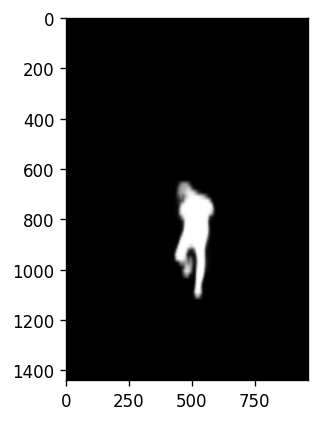

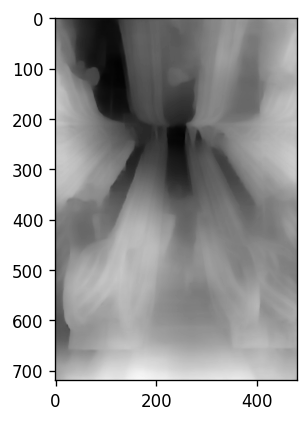

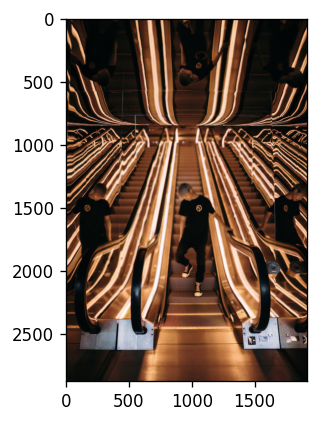

In [25]:
from skimage.transform import resize

j = 6
# plt.figure(dpi=120)
# plt.imshow(img)
plt.figure(dpi=120)
plt.imshow(mask_results[j][0][0][0], cmap='gray')
plt.figure(dpi=120)
plt.imshow(depth_results[j], cmap='gray')
plt.figure(dpi=120)
plt.imshow((bokeh_results[j][0]))

# I = np.zeros((mask[0].shape[0], mask[0].shape[1], 4))
# I[..., :3] = resize(bokeh_img[0], (mask[0].shape[0], mask[0].shape[1]))
# I[..., 3] = mask[0]
# plt.figure(dpi=120)
# plt.imshow(I)

# Image.fromarray((bokeh_img[0] * 255.).astype(np.uint8)).save(f"./res/results/{sample.stem}_bokeh_pretrain.png")